# Analysis of MGL2104 Data
Considering effects of different layers on acoustic energy

## Imports, Useful stuff, and Loading Data

In [1]:
import numpy as np
from numpy.matlib import repmat
from matplotlib import pyplot as plt

import xarray as xr
import sys
import os
from scipy import signal
import scipy.stats as stats
import time

from MGL2104_funcs import *
# from seismic_funcs import *

P190file = 'MGL2104_PD12_CSs/MGL2104PD12.0.p190'
c = 1480
Fs = 500


In [2]:
srcD = 15

AirgunVols = repmat(np.array([360,360,40,180,90,120,60,220,220]),4,1)
xg = repmat(np.array([-8, -8, -4.77, -2.41, 0.23, 2.69, 5, 8, 8]),4,1)
yg = np.ones([4,9])*np.array([[12],[4],[-4],[-12]])
zg = repmat(srcD + np.array([0.55, -0.2, -0.2, 0, 0, 0, 0, 0.55, -0.2]),4,1)

geometry = [xg,yg,zg]

goodRecInds = np.concatenate( ( np.arange(1,16,1), np.arange(17,28,1), np.arange(29,121,1) ) )


In [257]:
# Load P190 Data
# nav = readP190_2104('/media/asd21/My Passport/MGL2104_PD12_CSs/MGL2104PD12.0.p190')

# Bathymetry Stuff?

# Load SEL Data
SELdata = xr.load_dataset('/media/asd21/My Passport/MGL2104_Layer_Results')
SELall = SELdata['AllRefData']
SELfloor = SELdata['seafloorData']
SELmids = SELdata['midData']
SELcrust = SELdata['crustData']
offset = SELdata['offset']+5
shots = SELdata['shot']
freqs = np.array([25,32,40,50,63,80,100,125,159,200])
BWs = np.array([6,8,10,12,14,18,24,30,40,40])
# goodRecs = np.array(SELdata['recGood'])
goodRecs = np.arange(0,605,5)[goodRecInds]

for fi in range(SELcrust.shape[2]):
    for rec in range(SELcrust.shape[0]):
        tmp = np.copy(SELcrust[rec,:,fi])
        idx = np.where(tmp<0.1*np.mean(tmp))
        SELcrust[rec,idx[0],fi] = np.mean(tmp)
        idx = np.where(np.isnan(tmp))
        SELcrust[rec,idx[0],fi] = np.mean(tmp)
        
        tmp = np.copy(SELall[rec,:,fi])
        idx = np.where(tmp<0.1*np.mean(tmp))
        SELall[rec,idx[0],fi] = np.mean(tmp)
        idx = np.where(np.isnan(tmp))
        SELall[rec,idx[0],fi] = np.mean(tmp)

## Surface plots of all shots and receivers from each layer

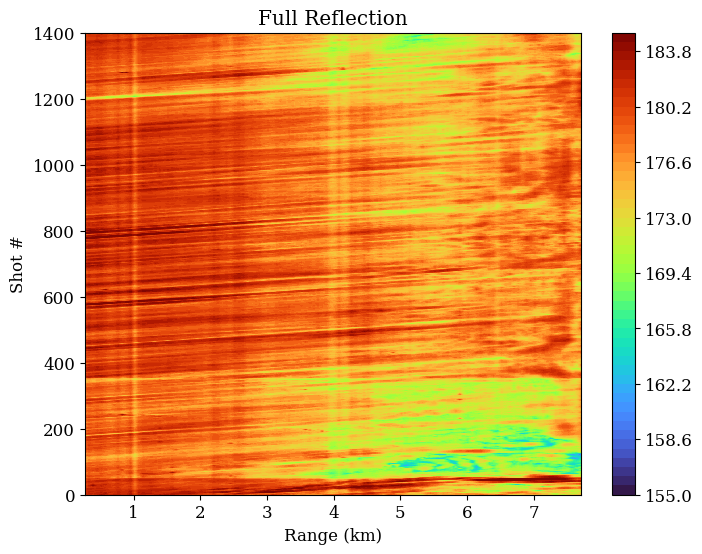

/home/asd21/miniconda3/envs/seismic/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


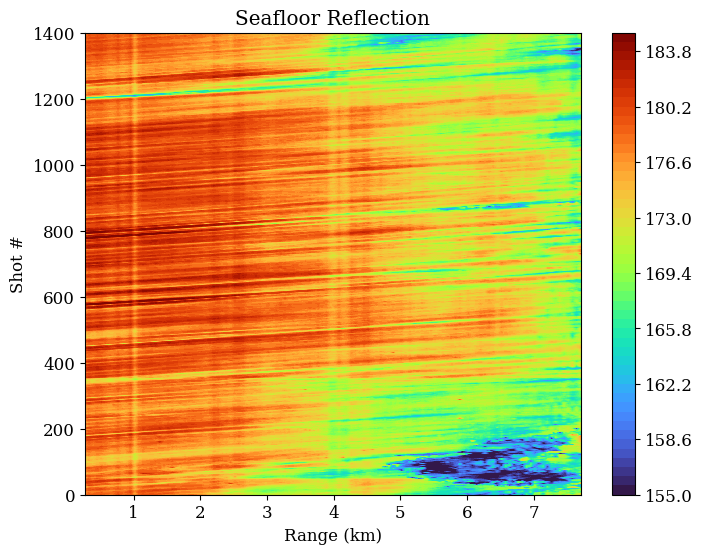

/home/asd21/miniconda3/envs/seismic/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


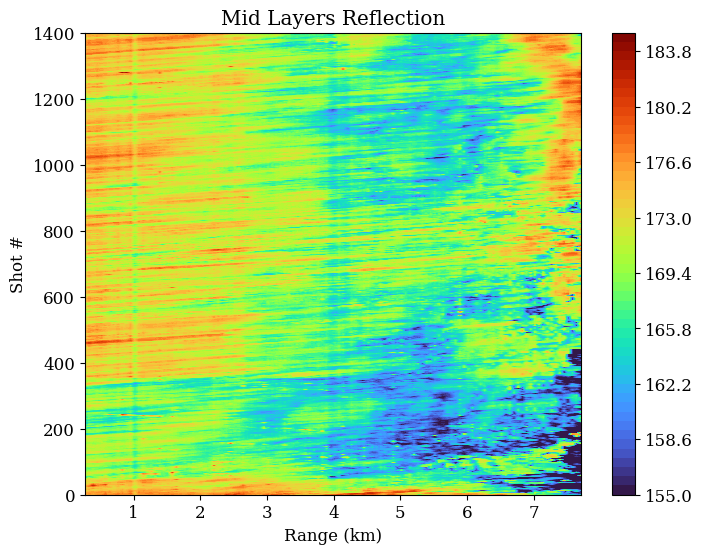

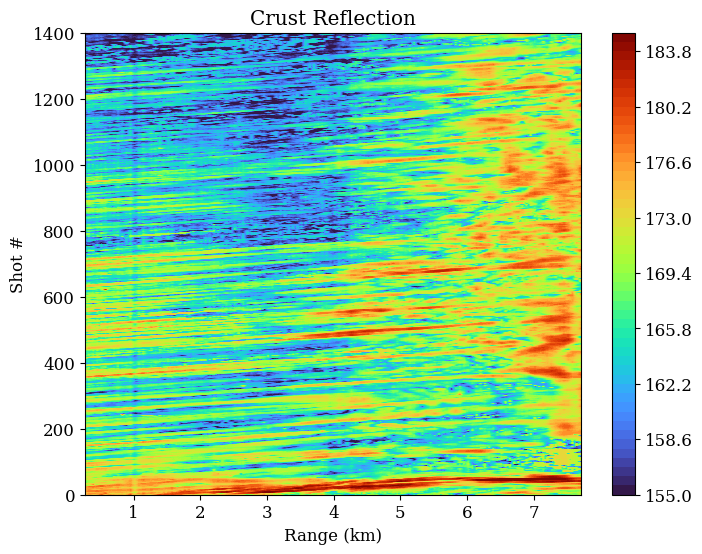

In [260]:
fi = 0
i = 0
shotLims = [0,1400]
cLimsdB = [155,185]
gauss_sig = 0
titles = ['Full Reflection','Seafloor Reflection','Mid Layers Reflection','Crust Reflection']
CMPFlag = 'Off'

# Make surface plots

if CMPFlag == 'On':
    
    for tmpdata in [SELall,SELfloor,SELmids,SELcrust]:
        dataSurf = np.array(20*np.log10(tmpdata[goodRecInds,:,fi].T*offset[goodRecInds]**0/(20e-6)))
        dataSurf,CMPshots = CSGtoCMP(dataSurf,goodRecs,Shot0=0,Shot1=1400,nShots=97)
        shotLims = [CMPshots[0],CMPshots[-1]]
        plotSurf(dataSurf,offset[goodRecInds]/1e3,CMPshots,xLims=[offset[1]/1e3,offset[-1]/1e3],yLims=shotLims,cLims=cLimsdB,xlabel='Range (km)',ylabel='Shot #',gauss_sig=0,plotsize=[8,6],title=titles[i])
        i += 1

else:
    
    for tmpdata in [SELall,SELfloor,SELmids,SELcrust]:
        dataSurf = np.array(20*np.log10(tmpdata[goodRecInds,:,fi].T*offset[goodRecInds]**0/(20e-6)))
        plotSurf(dataSurf,offset[goodRecInds]/1e3,shots,xLims=[offset[1]/1e3,offset[-1]/1e3],yLims=shotLims,cLims=cLimsdB,xlabel='Range (km)',ylabel='Shot #',gauss_sig=0,plotsize=[8,6],title=titles[i])
        i += 1


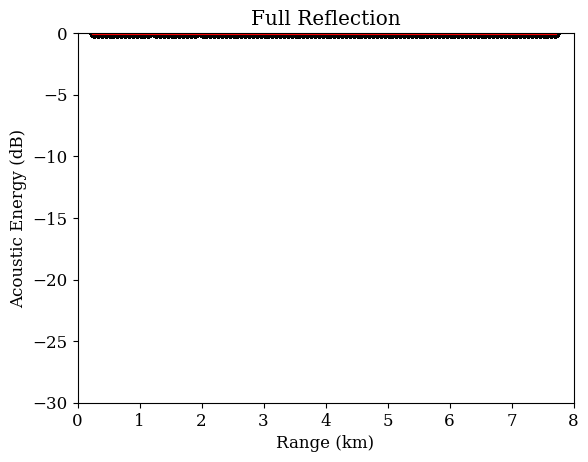

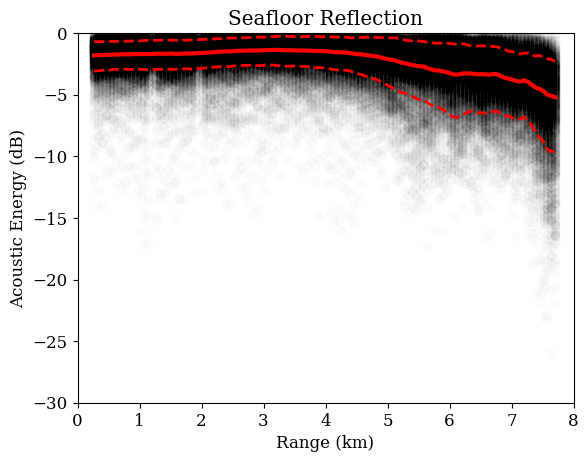

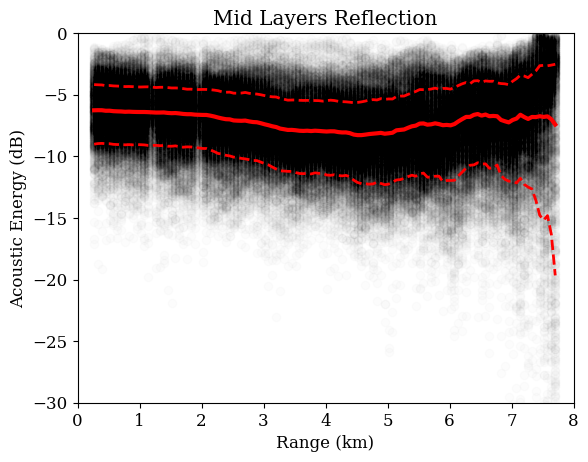

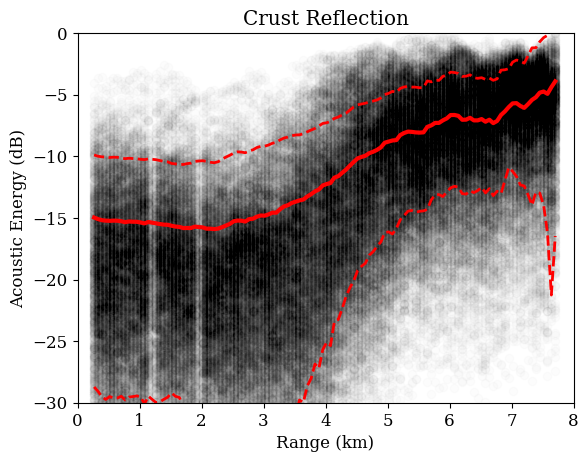

In [361]:

i = 0
fi = 1
xLims = [0,8]
yLims = [120,200]
titles = ['Full Reflection','Seafloor Reflection','Mid Layers Reflection','Crust Reflection']
normFlag = 'On'

# Make line plots
if normFlag == 'On':
    yLims = [-30,0]
    for tmpdata in [SELall,SELfloor,SELmids,SELcrust]:
        tmpdata = tmpdata/SELall*20e-6
        dataLine = np.array(tmpdata[goodRecInds,:,fi].T*offset[goodRecInds]**0)
        plotLine( dataLine , offset[goodRecInds]/1e3 , shotLims=[400,1400], title=titles[i],xlabel='Range (km)',ylabel='Acoustic Energy (dB)',xLims=xLims,yLims=yLims)
        i += 1
else:
    for tmpdata in [SELall,SELfloor,SELmids,SELcrust]:
        dataLine = np.array(tmpdata[goodRecInds,:,fi].T*offset[goodRecInds]**0)
        plotLine( dataLine , offset[goodRecInds]/1e3 , shotLims=[400,1400], title=titles[i],xlabel='Range (km)',ylabel='Acoustic Energy (dB)',xLims=xLims,yLims=yLims)
        i += 1


## Energy vs. Crust Depth

Rec: 5
Slope: -0.014800816580998051


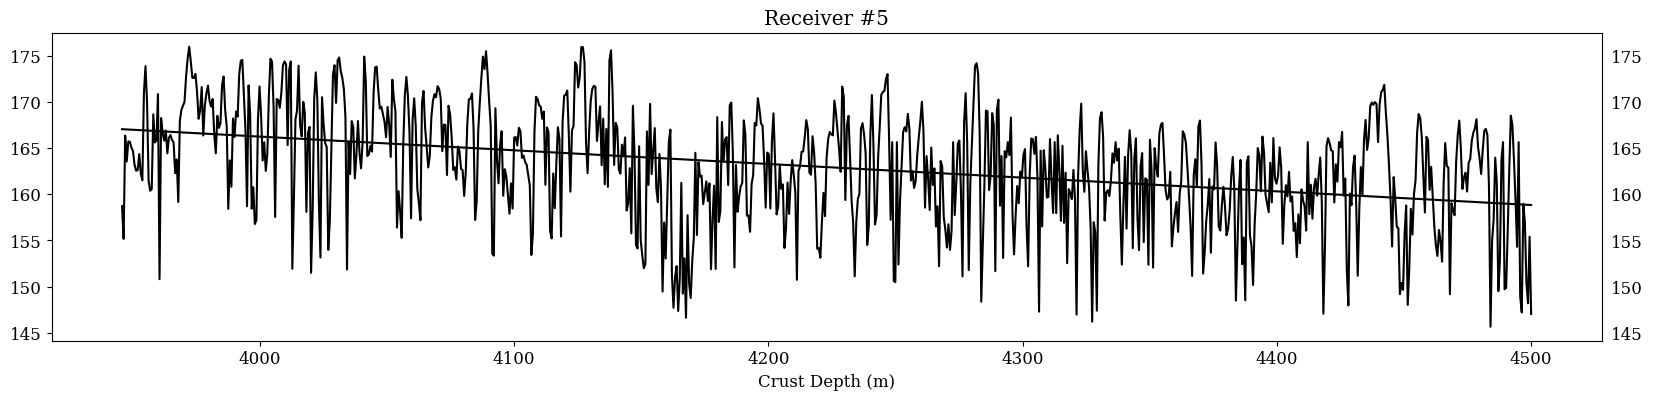

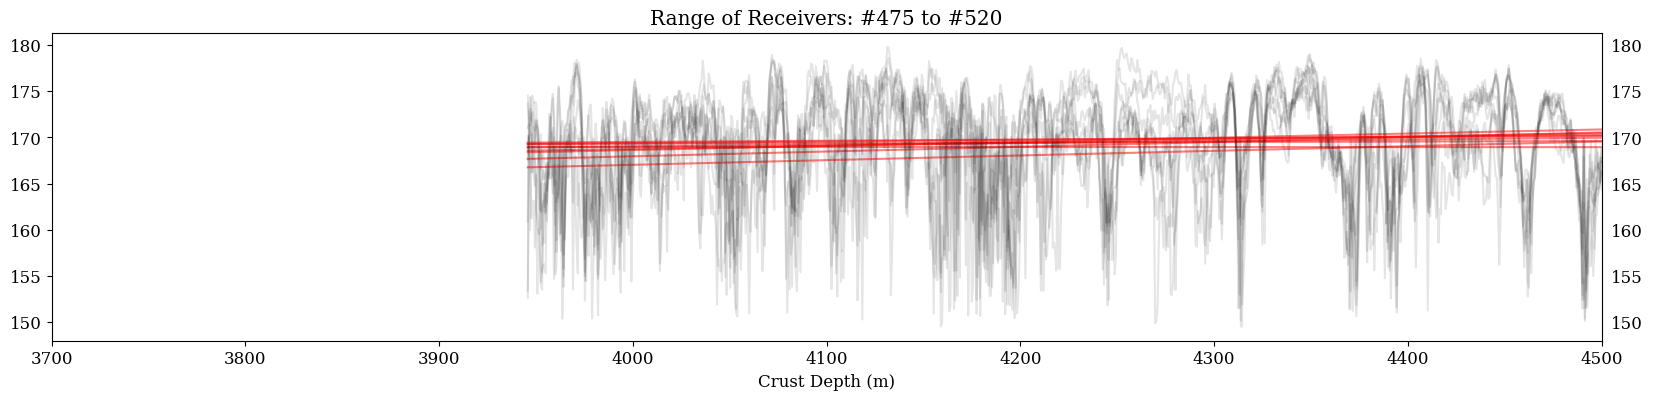

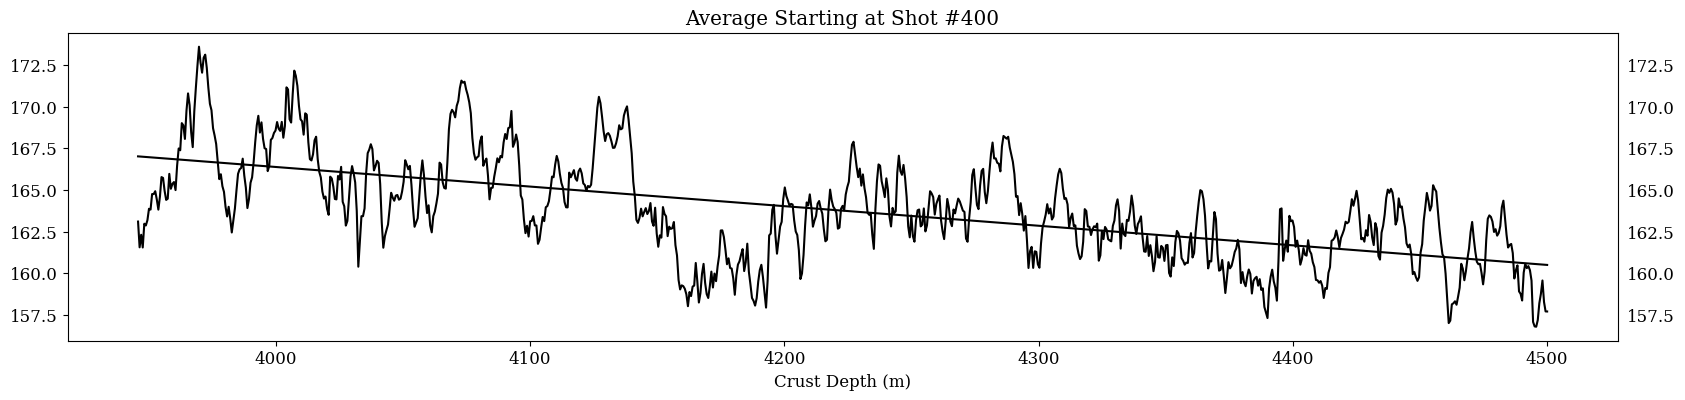

In [368]:

fi = 0

d1 = 3700
d2 = 4500
dCMP = np.linspace(d1,d2,1303)
shotStart = 400

dataCrust = np.array(20*np.log10(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0/(20e-6)))
dataCrust,CMPshots = CSGtoCMP(dataCrust,goodRecs,Shot0=0,Shot1=1400,nShots=97)
dataCrustMean = np.mean(dataCrust,axis=1)


# Plotting a single curve of SEL vs crust and fit lines
rec = 1
print('Rec: ' + str(rec*5))
dataTmp = dataCrust[shotStart:,rec]
for i in range(len(dataTmp)):
    if np.isnan(dataTmp[i]) == True or dataTmp[i] < 0:
        dataTmp[i] = (dataTmp[i-1]+dataTmp[i+1])/2

a, b = np.polyfit(dCMP[shotStart:], dataTmp,1)
print('Slope: ' + str(a))

plt.plot(dCMP[shotStart:],dataTmp,'k',alpha=1)
plt.plot(dCMP[shotStart:],a*dCMP[shotStart:]+b,'k',alpha=1)
plt.gcf().set_size_inches(20,4)
# plt.xlim([d1,d2])
plt.title('Receiver #' + str(rec*5))
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.show()



# Plotting a range of SEL vs crust and fit lines
rec0 = 92 #92
rec1 = 101 #101
for rec in range(rec0,rec1,1):#range(dataCrust.shape[1]):
    a, b = np.polyfit(dCMP[shotStart:], dataCrust[shotStart:,rec],1)
    plt.plot(dCMP[shotStart:],dataCrust[shotStart:,rec],'k',alpha=0.1)
    plt.plot(dCMP[shotStart:],a*dCMP[shotStart:]+b,'r',alpha=0.5)
    plt.gcf().set_size_inches(20,4)
    plt.xlim([d1,d2])
plt.title('Range of Receivers: #' + str(goodRecs[rec0]) + ' to #' + str(goodRecs[rec1]))
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.show()


# Plotting mean of SEL vs crust and fit line
plt.plot(dCMP[shotStart:],dataCrustMean[shotStart:],'k',alpha=1)
a, b = np.polyfit(dCMP[shotStart:], dataCrustMean[shotStart:],1)
plt.plot(dCMP[shotStart:],a*dCMP[shotStart:]+b,'k',alpha=1)
plt.gcf().set_size_inches(20,4)
# plt.xlim([d1,d2])
plt.title('Average Starting at Shot #' + str(shotStart))
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.show()


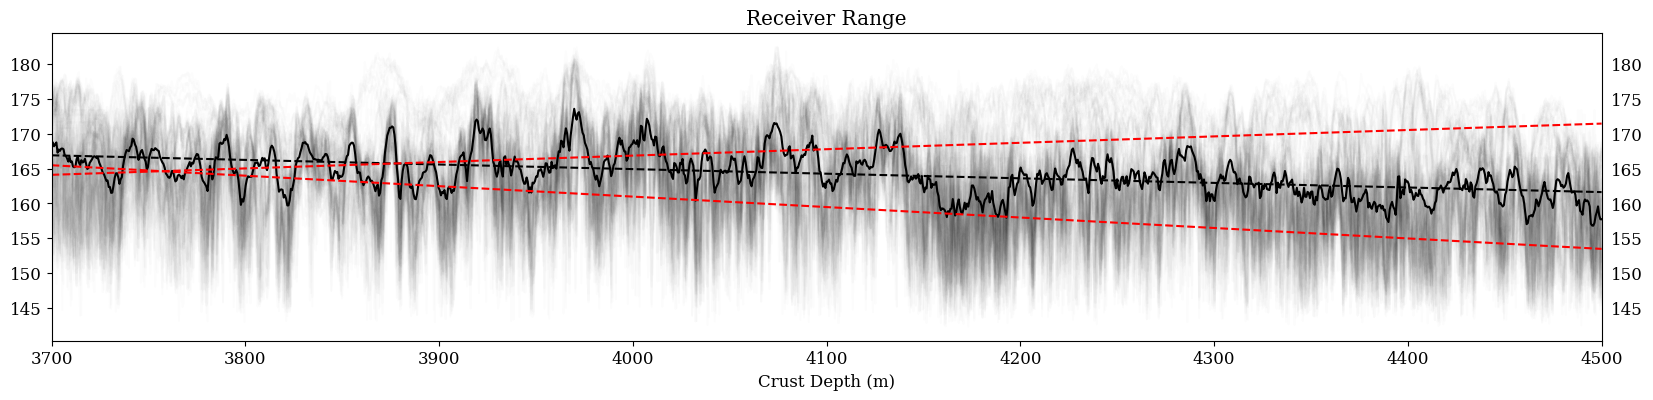

In [357]:

# Plotting a range of SEL vs crust and fit lines
aAll = []
bAll = []
for rec in range(dataCrust.shape[1]):
    a0, b0 = np.polyfit(dCMP[shotStart:], dataCrust[shotStart:,rec],1)
    aAll.append(a0)
    bAll.append(b0)
    plt.plot(dCMP[shotStart:],dataCrust[shotStart:,rec],'k',alpha=0.01)
    # plt.plot(dCMP[shotStart:],a*dCMP[shotStart:]+b,'r',alpha=0.5)
    plt.gcf().set_size_inches(20,4)
    plt.xlim([d1,d2])
idxMin = np.argmin(aAll)
idxMax = np.argmax(aAll)
plt.plot(dCMP[shotStart:],dataCrustMean[shotStart:],'k',alpha=1)
a, b = np.polyfit(dCMP[shotStart:], dataCrustMean[shotStart:],1)
plt.plot(dCMP[shotStart:],a*dCMP[shotStart:]+b,'k--',alpha=1)
plt.plot(dCMP[shotStart:],aAll[idxMax]*dCMP[shotStart:]+bAll[idxMax],'r--',alpha=1)
plt.plot(dCMP[shotStart:],aAll[idxMin]*dCMP[shotStart:]+bAll[idxMin],'r--',alpha=1)
plt.title('Receiver Range')
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.show()


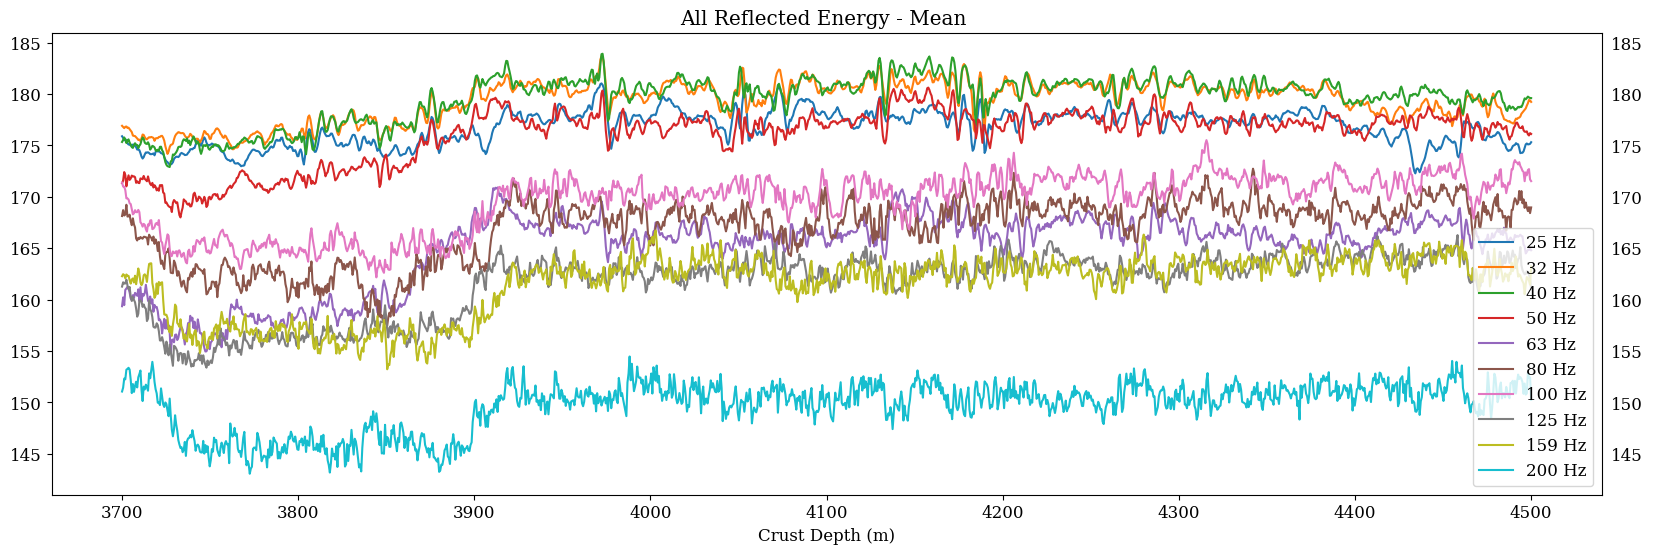

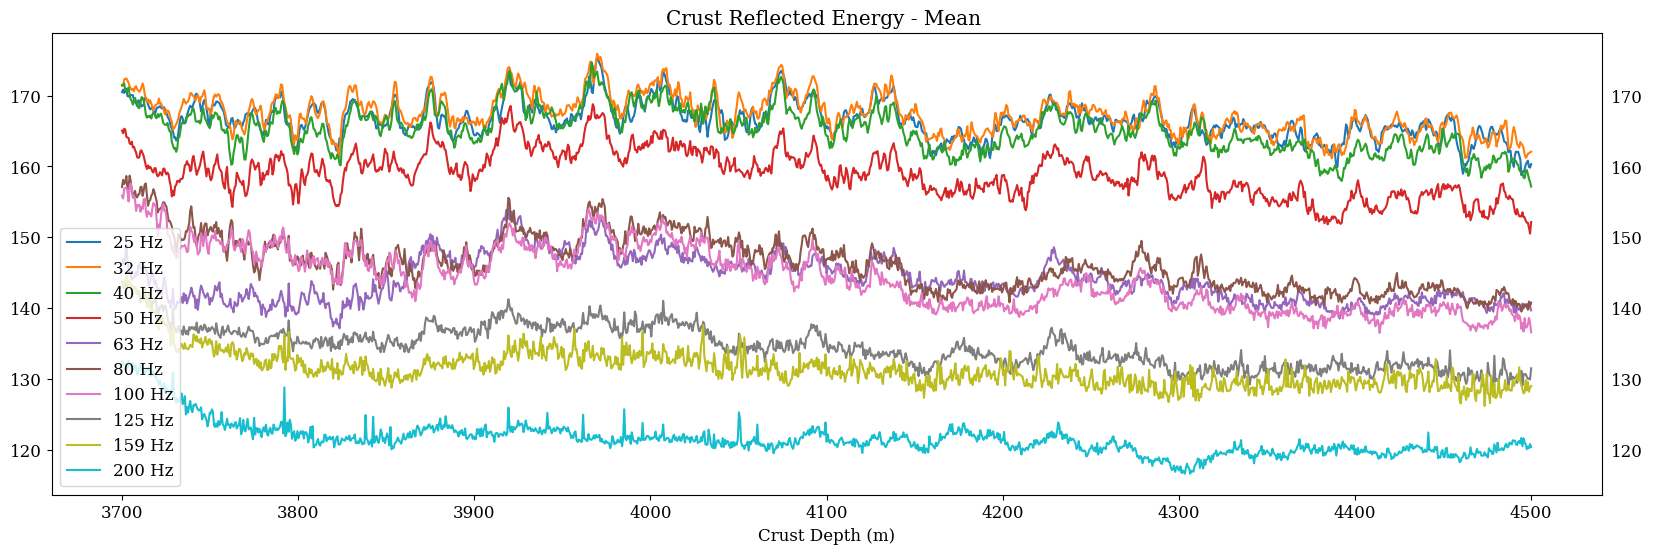

In [353]:

for fi in range(10):

    dataAll = np.copy(SELall[goodRecInds,:,fi].T*offset[goodRecInds]**0)
    dataAll,CMPshots = CSGtoCMP(dataAll,goodRecs,Shot0=0,Shot1=1400,nShots=97)
    dataAllMean = np.mean(dataAll,axis=1)
    dataAllMean = np.array(20*np.log10(dataAllMean/(20e-6)))
    # dataAllMean,CMPshots = CSGtoCMP(dataCrustMean,goodRecs,Shot0=0,Shot1=1400,nShots=97)
    
    plt.plot(dCMP[shotStart:],dataAllMean[shotStart:])
    
plt.title('All Reflected Energy - Mean of All Recs')
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.gcf().set_size_inches(20,6)
plt.legend(['25 Hz','32 Hz','40 Hz','50 Hz','63 Hz','80 Hz','100 Hz','125 Hz','159 Hz','200 Hz'])
plt.show()


for fi in range(10):

    dataCrust = np.copy(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0)
    dataCrust,CMPshots = CSGtoCMP(dataCrust,goodRecs,Shot0=0,Shot1=1400,nShots=97)
    dataCrustMean = np.mean(dataCrust,axis=1)
    dataCrustMean = np.array(20*np.log10(dataCrustMean/(20e-6)))
    # dataCrustMean,CMPshots = CSGtoCMP(dataCrustMean,goodRecs,Shot0=0,Shot1=1400,nShots=97)
    
    plt.plot(dCMP[shotStart:],dataCrustMean[shotStart:])
    
plt.title('Crust Reflected Energy - Mean of All Recs')
plt.xlabel('Crust Depth (m)')
plt.tick_params(labelright=True)
plt.gcf().set_size_inches(20,6)
plt.legend(['25 Hz','32 Hz','40 Hz','50 Hz','63 Hz','80 Hz','100 Hz','125 Hz','159 Hz','200 Hz'])
plt.show()
